## Overview
In this notebook the full dataset is broken into 26 subsets for each of the unique values of the kinase key. A random forest is fit to each of the subsets and evaluated using $k=5$-fold cross validation. The purpose in doing this is to determine which of the kinases are more difficult to classify and to verify reports that the fgfr1 kinase may have "bad" data. 

In [1]:
import pandas as pd
import time
import glob
import numpy as np
from scipy.stats import randint as sp_randint
from prettytable import PrettyTable
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, make_scorer 
from sklearn.ensemble import RandomForestClassifier

### Load the data
The data is distributed amongst 282  50mb .csv files, so the glob module is used to allow to read these files using a generic template path into a list, then the list elements are concated along the horizontal axis to create the full dataset. This takes about 10 minutes.

In [3]:
load_data_t0 = time.clock()
df = pd.concat([pd.read_csv(filename, index_col=[1,0], na_values=['na'], engine='c', header=0) for filename in glob.glob("data/parser_output/csv/*.csv")],axis=0)
load_data_t1 = time.clock()
print ("data loaded in ~", ((load_data_t1 - load_data_t0)/60), "minutes.")

data loaded in ~ 9.379375549999999 minutes.


after loading the data, extract the receptor names so that it is possible to form the seperate data subsets.

In [4]:
receptor_names = list(df.index.get_level_values(0).unique())

Now iterate through the list of receptors and extract the corresponding subset of training data from the full dataframe. Keep in mind that the number of examples in each set are not the same, therefore the average f1 of each subset is stored into a list for later visualization. A random forest is fit to each of the subsets using $k=5$-fold cross validation with the scoring metric set to the f1-score in order to capture presence type I (precision) and type II (recall) errors. Accuracy is not used due to the fact that the data is imbalanced and that a good accuracy score may be misleading regarding the performance of the classifier on correctly classifying positive training/testing examples.

 \begin{equation} Precision = \frac{TP}{TP + FP} \end{equation}
 \begin{equation} Recall = \frac{TP}{TP + FN} \end{equation}
 \begin{equation} F1 =  2* \frac{Precision*Recall}{Precision + Recall} \end{equation}

## Comparison of Classification with Random Forest Optimized using Randomized Grid Search


In [13]:
rforest_params = {"n_estimators": sp_randint(pow(2,5),pow(2,7))}

In [15]:
cv_score_list = []
outputTable = PrettyTable()
outputTable.field_names = ["receptor","N","%positive","Mean F1","Min F1","Max F1"]
for receptor in receptor_names:
    receptor_df = df.iloc[df.index.get_level_values(0) == receptor]
    X = Imputer().fit_transform(receptor_df.drop('label', axis=1).as_matrix())
    y = pd.to_numeric(receptor_df['label']).as_matrix()
    #rforest = RandomizedSearchCV(RandomForestClassifier(oob_score=True, class_weight='balanced'),  rforest_params, cv = 3, scoring = make_scorer(f1_score),n_jobs=3)
    rforest = RandomForestClassifier(oob_score=True, class_weight='balanced',n_estimators=100)
    cv_score = cross_val_score(rforest,X,y,scoring='f1',cv=5)
    cv_score_list.append(np.mean(cv_score))
    outputTable.add_row([receptor,receptor_df.shape[0],(100*(y[y==1].shape[0]/y.shape[0])),np.mean(cv_score),np.min(cv_score),np.max(cv_score)])
    del rforest
    del X
    del y
print(outputTable)

+----------+-------+--------------------+-----------------+----------------+-----------------+
| receptor |   N   |     %positive      |     Mean F1     |     Min F1     |      Max F1     |
+----------+-------+--------------------+-----------------+----------------+-----------------+
|  vgfr2   | 25896 | 2.378745752239728  |  0.764598897734 | 0.712041884817 |       0.8       |
|   abl1   | 11176 | 2.6216893342877596 |  0.651972471972 |      0.55      |  0.711111111111 |
|   met    | 11674 | 2.0729826965907145 |  0.754497483605 |      0.6       |  0.843373493976 |
|  mapk2   |  6448 | 3.163771712158809  |  0.70460783307  | 0.586206896552 |  0.876712328767 |
|   akt1   | 16990 | 2.4779281930547383 |  0.86279303567  | 0.773722627737 |  0.930817610063 |
|  tgfr1   |  8958 | 3.136860906452333  |  0.905018018505 | 0.836734693878 |  0.981818181818 |
|   lck    | 28535 | 2.3865428421237076 |  0.752511780327 | 0.653465346535 |  0.824034334764 |
|   src    | 35782 | 2.3084232295567606 |  0.80646

## Visualize the Results
To get an idea of how the random forest tends to perform across the subsets of data, a violin plot is used to communicate the median and inner-quartile ranges of the data as well as visualize the estimated density of the samples at each point. As one can see the distribution is multimodal which implies some abnormality if we expect the f1-scores for any particular subset to lie within a single peaked gaussian.

Mean F1: 0.725793409464 	Min F1: 0.0302027796765 	Max F1: 0.980688124306


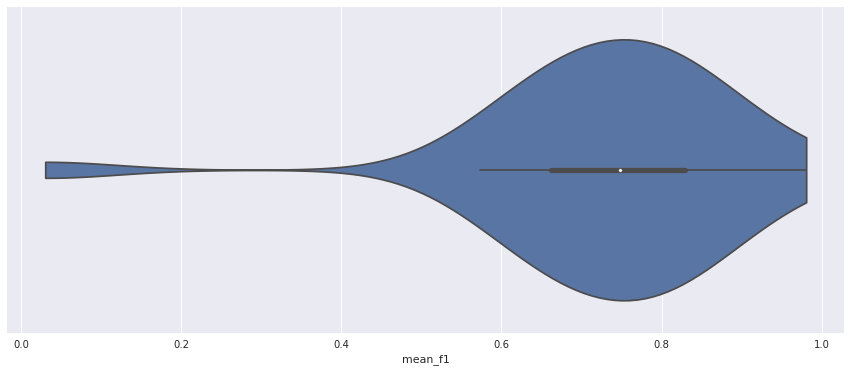

In [17]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=[15,6])
plt.xlabel("mean_f1")
sns.violinplot(x=cv_score_list, cut=0)

print ("Mean F1:",np.mean(cv_score_list),"\tMin F1:",np.min(cv_score_list),"\tMax F1:",np.max(cv_score_list))

## Conclusions
As it can be observed, the f1-scores for the classifiers do vary when using the random forest with default settings. However a notable result is the fgfr1 receptor being very difficult to correctly classify with a markedly low score as compared to the other receptors. This implies that either the receptor is in general difficult to classify or that there are potential mistakes for the actives and decoys in the data from the DUDE dataset. Perhaps what is surprising is that the positive class makes up a larger portion of the training examples for the fgfr1 receptor than what is typically 2-3% for the other receptors.